# Robotic Arm: Pick & Place Project Writeup

## For the Udacity Robotics Engineer Nanodegree

## By Harry Turner on 25th February 2018

----------------------------------------------------------------------

<b>1) Run the forward_kinematics demo and evaluate the kr210.urdf.xacro file to perform kinematic analysis of Kuka KR210 robot and derive its DH parameters.</b>

This section of the writeup explains how the forward kinematics for the Kuka KR210 were solved. First, the robot links were sketched, in their zero configuration, this can be seen in the image below.

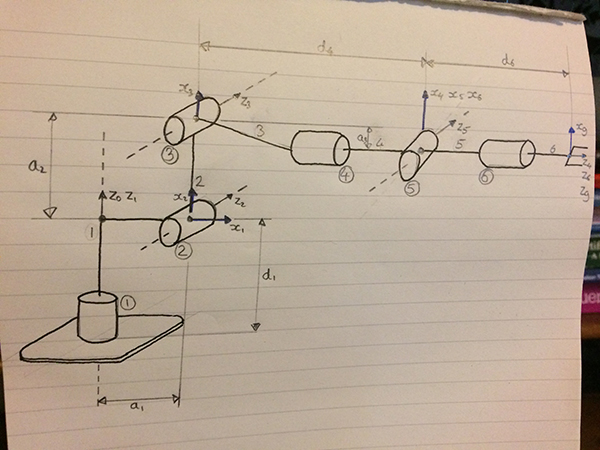

Each frame was assigned a coordinate frame in alignment with the DH convention. This allowed the DH parameters to be extracted by following the DH parameter assignment algorithm. Values for <b>a</b> and <b>d</b> were obtained from the KR210's URDF file.

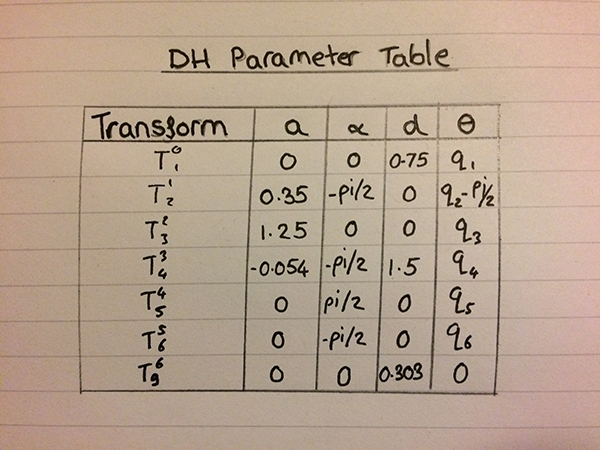

<b>2) Using the DH parameter table you derived earlier, create individual transformation matrices about each joint. In addition, also generate a generalized homogeneous transform between base_link and gripper_link using only end-effector(gripper) pose.</b>

The DH convention allows a transform from link <b>a</b> to <b>b</b> to be described with four degrees of freedom, by constraining the other two degrees of freedom. The DH transform itself is a composition of a rotation about <b>x</b>, followed by a translation along <b>x</b>, followed by a rotation about <b>z</b>, finally followed by a translation along <b>z</b>. Each of these individual transformations have a homogeneous transform associated with them, these four transformations can be multipled together to produce the homogeneous transform for the complete transformation from <b>a</b> to <b>b</b>. The generic form of the homogeneous transform for a DH transformation is shown below.

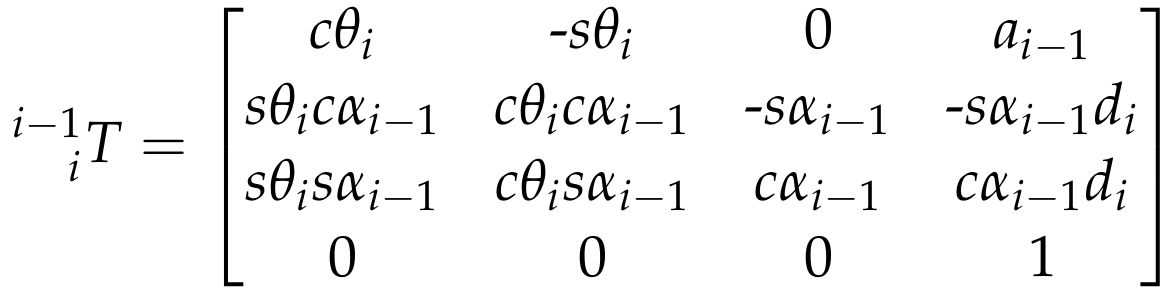

From the DH parameter table, we know the values of a, alpha, d, and theta. These can be substituted into the generic form of the matrix above to produce the actual transforms from link to link. These are stated below.

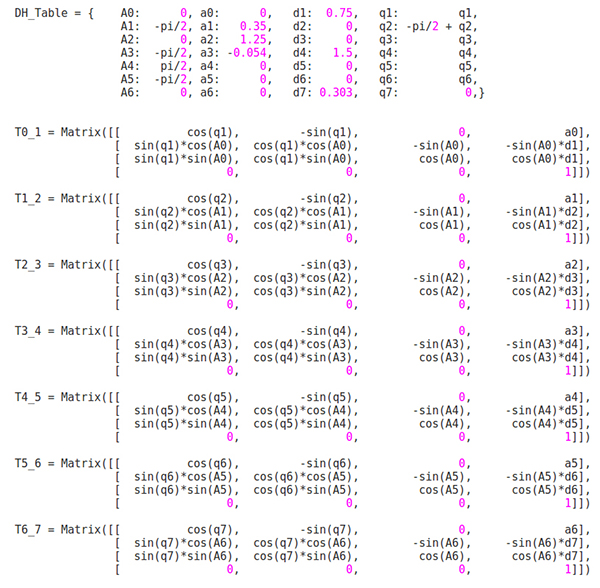

Finally, all of the transformations can be multiplied together to produce the full transformation from the base link to the gripper. 

<b>3) Decouple Inverse Kinematics problem into Inverse Position Kinematics and inverse Orientation Kinematics; doing so derive the equations to calculate all individual joint angles.</b>

Because the KR210 has a spherical wrist, we can decouple the inverse kinematics into two problems, solving the position of the wrist centre, and then solving for the orientation of the end effector.

<b> Solving Position</b>

The position is determined by the first three joint angles. It can be solved analytically, or numerically. Here it will be solved analytically. Equations for the three joint angles will be found in closed form, by analysing the geometry of the links, and using trigonometry.

<b>Theta 1</b>

<b>Theta 1</b> can be solved fairly trivially, since joints 2 and 3 lie in a plane. We can solve for joint 1 by simplying applying trigonometry to the x and y position of the wrist centre. This is illustrated in the image below, which comes from <b><i>"Robot Modelling and Control, Chapter 5".</i></b>

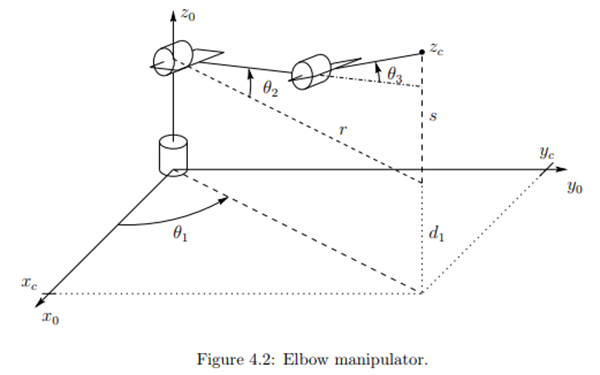

The equation for theta 1 is as follows.

In [ ]:
# Theta 1
#####################################

theta1 = atan2(y0,x0)

<b>Theta 2 and Theta 3</b>

Equations for <b>theta 2</b> and <b>theta 3</b>, can be derived by inspecting the figure below. It is a depiction of the first three links.

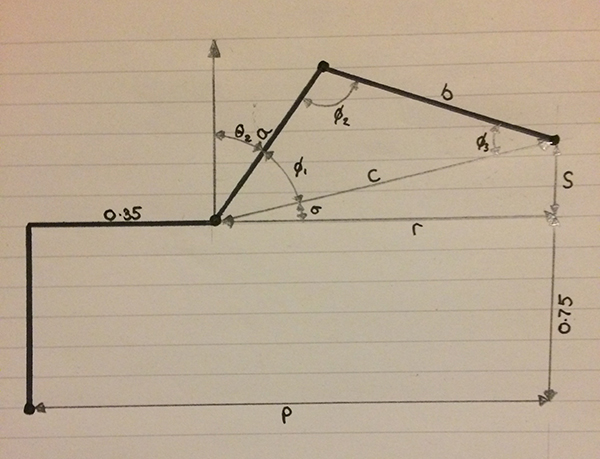

<b>Theta 2</b> can be found if <b>phi_1</b> is known, and <b>rho</b> is known, as these can be subtracted from 90 degrees. To find <b>phi_1</b>, we can apply the cosine rule to <b>a</b>, <b>b</b>, and <b>c</b>. To find <b>rho</b>, we can apply the <b>atan</b> function to <b>r</b>, and <b>s</b>. We know <b>s</b>. since we know the height of the end effector, and we know <b>r</b>, because <b>p</b> can be found from the <b>x</b> and <b>y</b> positions of the end effector. The equation for <b>theta 2</b> is below. Note that since <b>theta 2</b> can be solved to give two values, I have chosen the elbow up, value.

In [ ]:
# Theta 2
#####################################
            
theta2 = pi/2 - phi1 - atan2((z-0.75),(sqrt(x*x + y*y) - 0.35))

The image below is of the second and third links.

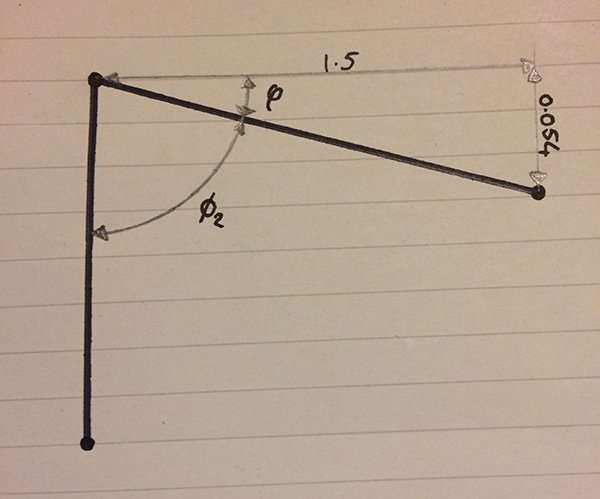

<b>Theta 3</b> can be found by subtracting <b>phi_2</b>, and <b>gamma</b>, from 90 degrees. We already know <b>phi_2</b>, and can find <b>gamma</b> using trigonometry. Equation for <b>theta 3</b> is below.

In [ ]:
# Theta 3
#####################################
            
theta3 = pi/2 - phi2 - 0.036

<b>Solving Orientation</b>

Now that we have the values for the first three joint angles, we can find the orientation of the wrist using the following equation.

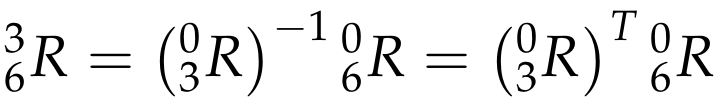

The wrist orientation can be represented by an euler rotation, illustrated in the figure below. Note that in this illustration, the values of <b>alpha</b>, <b>beta</b>, and <b>gamma</b>, represent <b>theta 4</b>, <b>theta 5</b>, and <b>theta 6</b>.

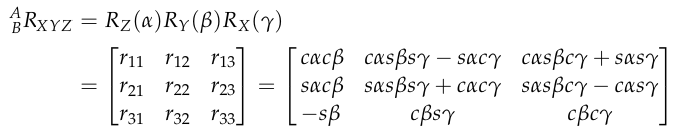

The values for <b>theta 4</b>, <b>theta 5</b>, and <b>theta 6</b>, can be extracted from the rotation matrix using the following equations.

In [ ]:
theta4 = atan2(r21, r11) * rtd
theta5 = atan2(-r31, sqrt(r11 * r11 + r21 * r21)) * rtd
theta6 = atan2(r32, r33) * rtd

In the actual code, a different euler rotation matrix is used, so the equations to extract the joint angles are different, however the basic idea is the same.

<b>4) Fill in the IK_server.py file with properly commented python code for calculating Inverse Kinematics based on previously performed Kinematic Analysis. Your code must guide the robot to successfully complete 8/10 pick and place cycles. A screenshot of the completed pick and place process is included.</b>

The forward kinematics code for this project is as follows.

In [ ]:
# Define D-H parameters
#######################

d1, d2, d3, d4, d5, d6, d7 = symbols('d1:8')   
q1, q2, q3, q4, q5, q6, q7 = symbols('q1:8') 
q1, q2, q3, q4, q5, q6, q7 = symbols('q1:8')
a0, a1, a2, a3, a4, a5, a6 = symbols('a0:7')
alpha0, alpha1, alpha2, alpha3, alpha4, alpha5, alpha6 = symbols('alpha0:7')

# Distance and Angle (in meters and radians)
d0_1 = 0.75
d3_4 = 1.5
d4_7 = 0.303

a1_2 = 0.35
a2_3 = 1.25
a3_4 = -0.054

alpha1_2 = -pi/2
alpha3_4 = -pi/2
alpha4_5 =  pi/2
alpha5_6 = -pi/2


# Construct DH Parameter Table
##############################

DH_Table = {    alpha0:      0, a0:      0,   d1:  0.75,   q1:         q1,
                alpha1:  -pi/2, a1:   0.35,   d2:     0,   q2: -pi/2 + q2,
                alpha2:      0, a2:   1.25,   d3:     0,   q3:         q3,
                alpha3:  -pi/2, a3: -0.054,   d4:   1.5,   q4:         q4,
                alpha4:   pi/2, a4:      0,   d5:     0,   q5:         q5,
                alpha5:  -pi/2, a5:      0,   d6:     0,   q6:         q6,
                alpha6:      0, a6:      0,   d7: 0.303,   q7:          0,}


# Define a function for quickly generating homogeneous transforms
#################################################################

def generate_homogeneous_transform(A, a, d, q):

        m = Matrix([[          cos(q),       -sin(q),       0,         a],
                    [ sin(q)*cos(A), cos(q)*cos(A), -sin(A), -sin(A)*d],
                    [ sin(q)*sin(A), cos(q)*sin(A),  cos(A),  cos(A)*d],
                    [             0,             0,       0,         1]])
        return m


# Construct individual transformation matrices
##############################################
    
T0_1 = generate_homogeneous_transform(alpha0,a0,d1,q1).subs(DH_Table)
T1_2 = generate_homogeneous_transform(alpha1,a1,d2,q2).subs(DH_Table)
T2_3 = generate_homogeneous_transform(alpha2,a2,d3,q3).subs(DH_Table)
T3_4 = generate_homogeneous_transform(alpha3,a3,d4,q4).subs(DH_Table)
T4_5 = generate_homogeneous_transform(alpha4,a4,d5,q5).subs(DH_Table)
T5_6 = generate_homogeneous_transform(alpha5,a5,d6,q6).subs(DH_Table)
T6_7 = generate_homogeneous_transform(alpha6,a6,d7,q7).subs(DH_Table)


# Construct the full transformation from base link to end effector
##################################################################

T0_2 = T0_1 * T1_2
T0_3 = T0_2 * T2_3
T0_4 = T0_3 * T3_4
T0_5 = T0_4 * T4_5
T0_6 = T0_5 * T5_6
T0_7 = T0_6 * T6_7


# Extract rotation matrices
###########################

R0_1 = T0_1[0:3,0:3]
R0_2 = T0_2[0:3,0:3]
R0_3 = T0_3[0:3,0:3]
R0_4 = T0_4[0:3,0:3]
R0_5 = T0_5[0:3,0:3]
R0_6 = T0_6[0:3,0:3]
R0_7 = T0_7[0:3,0:3]

The forward kinematics code starts by defining the DH parameters, and using those parameters to construct the DH parameter table. A function is created to quickly generate a homogeneous transformation, given the four parameters. The seven transformation matrices for each link are then created, by passing in the relevant values from the DH parameter table. Finally, the homogeneous transform from the base link to the end effector is calculated, and the rotation matrixes for each transformation are extracted from their corresponding homegeneous matrices.

The inverse kinematics code for this project is as follows.

In [ ]:
# Extract end effector positions
#####################################

px = req.poses[x].position.x
py = req.poses[x].position.y
pz = req.poses[x].position.z


# Extract R, P, and Y
#####################################

(r, p, y) = tf.transformations.euler_from_quaternion(
            [req.poses[x].orientation.x, req.poses[x].orientation.y,
            req.poses[x].orientation.z, req.poses[x].orientation.w])

# R_rpy = roll, pitch, yaw
R_rpy =  Matrix([[cos(y)*cos(p), cos(y)*sin(p)*sin(r)-sin(y)*cos(r), cos(y)*sin(p)*cos(r)+sin(y)*sin(r)],
                 [sin(y)*cos(p), sin(y)*sin(p)*sin(r)+cos(y)*cos(r), sin(y)*sin(p)*cos(r)-cos(y)*sin(r)],
                 [-sin(p),         cos(p)*sin(r),                             cos(p)*cos(r)]])

# Compute Correction Matrix
#####################################

R_corr = Matrix([[0,0,1],
                 [0,-1,0],
                 [1,0,0]])
            
# Calculate the origin matrix by the rpy and correlation transpose
Rrpy = R_rpy*(R_corr.T)

# Compute EE Matrix
#####################################

EE = Matrix([[px],
                         [py],
                         [pz]])

# Compute Wrist Center
#####################################

wc = EE - d4_7 * Rrpy[:,2]

# Theta 1
#####################################
theta1 = atan2(wc[1],wc[0])


# Calculate a, b, c 
#####################################

a = a2_3
c = sqrt(pow((sqrt(wc[0] * wc[0]+wc[1] * wc[1]) - 0.35),2)+pow((wc[2] - 0.75), 2))
b = sqrt(d3_4**2+a3_4**2)

# Take the inverse cosine to get the angle (phi)
phi1 = acos((c * c + a * a -b * b) / (2 * c * a))
phi2 = acos((b * b + a * a -c * c) / (2 * b * a))
phi3 = acos((c * c + b * b -a * a) / (2 * c * b))

# Theta 2
#####################################
            
theta2 = pi/2 - phi1 - atan2((wc[2]-0.75),(sqrt(wc[0] * wc[0]+wc[1] * wc[1]) - 0.35))
            

# Theta 3
#####################################
            
theta3 = pi/2 - phi2 - 0.036

# Calculate rotational matrices
R0_3_solved = R0_3.evalf(subs={q1: theta1, q2: theta2, q3: theta3})
R3_6 = R0_3_solved.T * Rrpy

# Use the previous information to acquire the remaining angles (theta)
theta4 = atan2(R3_6[2,2], -R3_6[0,2])
theta5 = atan2(sqrt(R3_6[0,2]*R3_6[0,2] + R3_6[2,2]*R3_6[2,2]),R3_6[1,2])
theta6 = atan2(-R3_6[1,1],R3_6[1,0])

The code starts by extracting the end effector position and orientation. The wrist centre is then computed by moving along <b>z</b> from the end effector position. From the wrist centre, the first three joint angles can be found using the closed form geometric equations. Now that the first three joint angles have been found, the rotation matrix from the base link to the third link can be found. This determines an orientation for the wrist centre, given the first three links. To get the values of the last three links, the orientation due to the first three links is inverted and multiplied by the total orientation of the end effector. 

<b>Discussion</b>

The forward and inverse kinematics were solved for the Kuka KR210 in this project. The code was tested in the IK_Debugger, and managed to find the correct values for the end effector position, wrist centre, and theta values. This gave me confidence to transfer the code to the actual IK_Server. The robot was then tested with the new code, and managed to navigate to the object, pick it up, navigate to the bin, and drop the object again. Therefore, the forward and inverse kinematic code for the robot are correct. 

Occasionally, the robot does drop the object, and occasionally fails to pick it up completely, despite it navigating to the object correctly.

A final screenshot of the robot dropping the object into the bin is as follows.

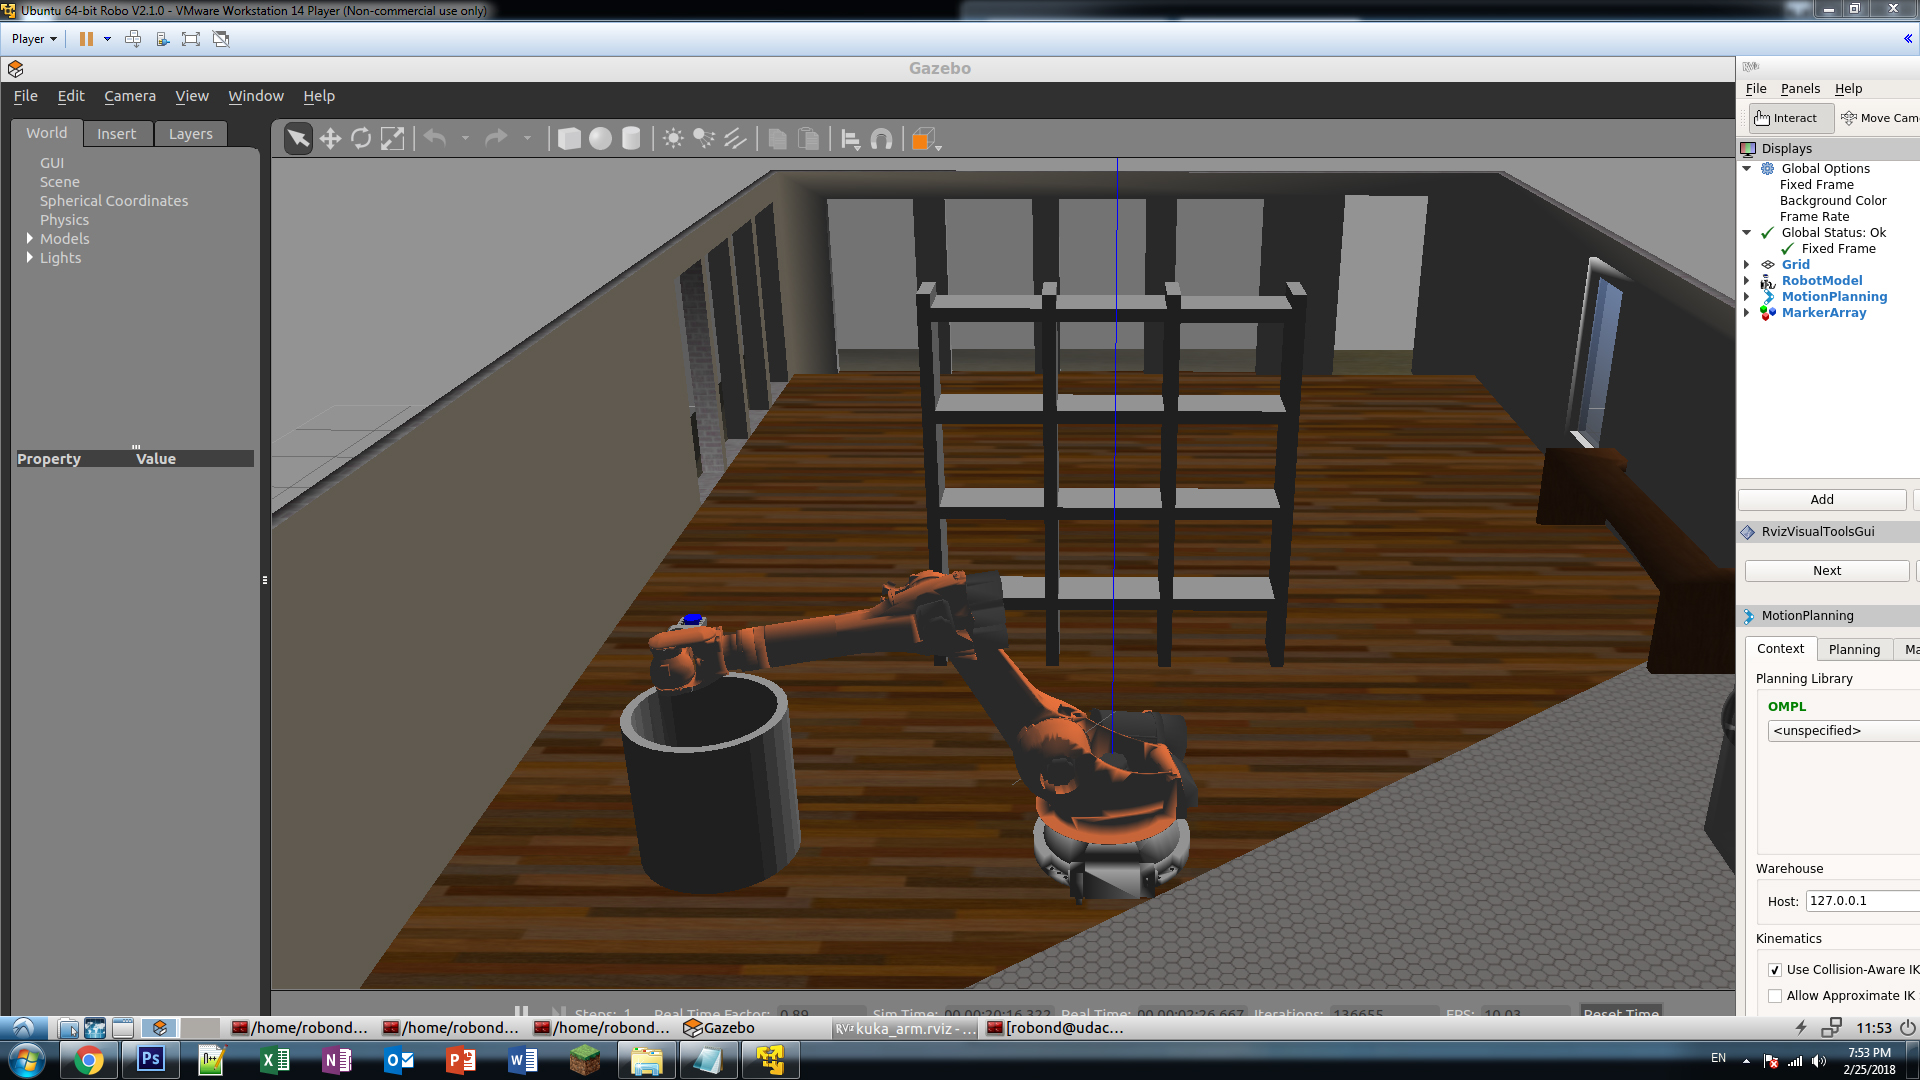